In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)




In [3]:
# conda activate aso_design
import pandas as pd
from scripts.data_genertion.consts import *
from asodesigner.file_utils import read_human_genome_fasta_dict
from asodesigner.consts import *
all_data = pd.read_csv(DATA_PATH_NEW / 'data_asoptimizer_updated.csv')
all_data.head()

/tmp/ipykernel_3037894/625257175.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(DATA_PATH_NEW / 'data_asoptimizer_updated.csv')


,index,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,...,Inhibition(%),seq_length,Canonical Gene Name,Cell line organism,Transcript,Location_in_sequence,Location_div_by_length,true_length_of_seq,mod_scan,cell_line_uniform
0,0,540733,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCTAAAACAAATGCTA,...,33.0,16,KRAS,human,NaN,41212.0,0.901972,16,0,A431
1,1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,...,7.0,16,KRAS,human,NaN,23686.0,0.518395,16,0,A431
2,2,540806,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCATGAAGATTTCTGG,...,62.0,16,KRAS,human,NaN,43363.0,0.949049,16,1,A431
3,3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,...,28.0,16,KRAS,human,NaN,23680.0,0.518264,16,0,A431
4,4,651490,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,CACTTGTACTAGTATG,...,36.0,16,KRAS,human,NaN,41168.0,0.901009,16,0,A431


In [4]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")    

Feture generation

clean the data

In [5]:
import numpy as np

all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001)

In [6]:
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [7]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR


cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [9]:
# =========================
# External mRNA integration
# =========================
import pandas as pd
from pathlib import Path
import re

def _norm_rna_to_dna(seq: str) -> str:
    """Normalize RNA to DNA alphabet (U->T), uppercase, strip whitespace."""
    return str(seq).upper().replace('U', 'T').replace(' ', '').replace('\t', '').replace('\n', '')


def load_mrna_by_gene_from_files(files: list[str | Path],seq_column: str = "Original Transcript Sequence" ) -> dict[str, str]:
    """
    Load {Gene -> <seq_column>} from a manual list of CSV paths.
    - Expects columns: 'Gene' and <seq_column>
    - Returns DNA alphabet (A/C/G/T) after U->T via _norm_rna_to_dna
    - If multiple rows per gene: keeps the *longest* sequence
    """
    files = [Path(f) for f in files]
    rows = []
    for f in files:
        df = pd.read_csv(f, usecols=['Gene', seq_column])
        df[seq_column] = df[seq_column].map(_norm_rna_to_dna)
        # Keep only clean sequences
        df = df[df[seq_column].str.fullmatch(r'[ACGT]+', na=False)]
        rows.append(df)

    if not rows:
        return {}

    big = pd.concat(rows, ignore_index=True)
    big['len'] = big[seq_column].str.len()
    # Pick longest per gene
    chosen = big.sort_values(['Gene', 'len'], ascending=[True, False]).drop_duplicates('Gene')
    return dict(zip(chosen['Gene'], chosen[seq_column]))

# ---- Choose which mRNA to use for mRNA-based features (tAI/windows on mRNA, etc.) ----
def choose_preferred_mrna(gene_name: str, mrna_built_from_exons: str, gene_to_mrna_real: dict[str,str]) -> str:
    """
    Prefer the real (external) mRNA when available; otherwise fall back to exon-joined.
    Does NOT touch your genome->(mRNA/CDS) mappings or pre-mRNA flanks.
    """
    ext = gene_to_mrna_real.get(gene_name)
    return ext if ext else mrna_built_from_exons


In [10]:
from pathlib import Path
import pandas as pd

DATA_mRNA_PATH = PROJECT_PATH / "scripts" / "data_genertion" / "cell_line_expression"

FILENAMES = [
    "ACH-000232_transcriptome.csv",
    "ACH-000463_transcriptome.csv",
    "ACH-000739_transcriptome.csv",
    "ACH-001086_transcriptome.csv",
    "ACH-001188_transcriptome.csv",
    "ACH-001328_transcriptome.csv",
]

EXTERNAL_MRNA_FILES = [DATA_mRNA_PATH / fn for fn in FILENAMES]
missing = [p.name for p in EXTERNAL_MRNA_FILES if not p.exists()]
assert not missing, f"Missing files in {DATA_mRNA_PATH}: {missing}"

# 1) Load Original
try:
    d_orig = load_mrna_by_gene_from_files(
        [str(p) for p in EXTERNAL_MRNA_FILES],
        seq_column="Original Transcript sequence"
    )
except ValueError:
    # in case the S is capitalized in your headers
    d_orig = load_mrna_by_gene_from_files(
        [str(p) for p in EXTERNAL_MRNA_FILES],
        seq_column="Original Transcript Sequence"
    )

# 2) Load Mutated
try:
    d_mut = load_mrna_by_gene_from_files(
        [str(p) for p in EXTERNAL_MRNA_FILES],
        seq_column="Mutated Transcript sequence"
    )
except ValueError:
    d_mut = load_mrna_by_gene_from_files(
        [str(p) for p in EXTERNAL_MRNA_FILES],
        seq_column="Mutated Transcript Sequence"
    )

# 3) Prefer Mutated when available
gene_to_mrna_real = {**d_orig, **d_mut}

print(f"Loaded {len(gene_to_mrna_real)} real mRNA sequences (Gene -> mRNA).")



Loaded 17546 real mRNA sequences (Gene -> mRNA).


In [11]:
from asodesigner.util import get_antisense
import numpy as np

# Filter relevant genes
all_data_human_gene = all_data_no_nan_human[
    all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)
].copy()

# Column names
SENSE_START       = 'sense_start'          # Genomic index of ASO binding site in pre-mRNA
SENSE_LENGTH      = 'sense_length'         # Length of the ASO (nt)
SENSE_TYPE        = 'sense_type'           # exon / intron
CDS_SEQUENCE      = 'cds_sequence'         # CDS string (joined exons within CDS range)
IN_CODING_REGION  = 'in_coding_region'     # site is within CDS on a real exon

# Flank sizes
FLANK_SIZES_PREMRNA = [20, 30, 40, 50, 60, 70]
FLANK_SIZES_CDS     = [20, 30, 40, 50, 60, 70]

# Initialize columns
all_data_human_gene[SENSE_START]      = 0
all_data_human_gene[SENSE_LENGTH]     = 0
all_data_human_gene[SENSE_TYPE]       = "NA"
all_data_human_gene[CDS_SEQUENCE]     = ""
all_data_human_gene[IN_CODING_REGION] = False

for fs in FLANK_SIZES_PREMRNA:
    all_data_human_gene[f"flank_sequence_{fs}"] = ""
for fs in FLANK_SIZES_CDS:
    all_data_human_gene[f"local_coding_region_around_ASO_{fs}"] = ""

# ---- helpers (local to Part B) ----
def _to_str_seq(x) -> str:
    """
    Coerce sequence-like (list/np.array/Series) or string to a clean uppercase DNA string.
    Converts U->T and strips whitespace. Ensures slicing returns a plain string (avoids pandas iterable assignment).
    """
    if isinstance(x, str):
        s = x
    else:
        try:
            s = ''.join(list(x))
        except Exception:
            s = str(x)
    return s.replace(' ', '').replace('\t', '').replace('\n', '').replace('U', 'T').upper()

def _build_spliced_mrna_from_exons(pre_mrna: str, exon_indices):
    """
    Build exon-joined mRNA by concatenating exon slices out of pre_mrna.
    Keeps your original assumptions: pre_mrna corresponds to genomic strand and
    starts at exon_indices[0][0]; exon intervals are used directly.
    """
    if not exon_indices:
        return ""
    pre_genome_start = exon_indices[0][0]
    parts = []
    for exon_start, exon_end in exon_indices:
        pm_start = exon_start - pre_genome_start
        pm_end   = exon_end   - pre_genome_start
        parts.append(pre_mrna[pm_start:pm_end])
    return "".join(parts)

# Cache CDS per gene
gene_to_cds_info = {}

# ---- main loop ----
for index, row in all_data_human_gene.iterrows():
    gene_name  = row[CANONICAL_GENE]
    locus_info = gene_to_data[gene_name]

    # Keep using your current pre-mRNA for flanks/exon-intron logic (coerced to clean string)
    pre_mrna  = _to_str_seq(locus_info.full_mrna)
    antisense = _to_str_seq(row[SEQUENCE])
    sense     = _to_str_seq(get_antisense(antisense))

    # Locate site on pre-mRNA
    idx = pre_mrna.find(sense)
    all_data_human_gene.at[index, SENSE_START]  = idx
    all_data_human_gene.at[index, SENSE_LENGTH] = len(antisense)

    if idx != -1:
        # Genomic correction (kept as-is)
        genome_corrected_index = idx + locus_info.exon_indices[0][0]

        # exon / intron classification (kept as-is: inclusive check)
        region_type = "intron"
        for exon_start, exon_end in locus_info.exon_indices:
            if exon_start <= genome_corrected_index <= exon_end:
                region_type = "exon"
                break
        all_data_human_gene.at[index, SENSE_TYPE] = region_type

        # pre-mRNA flanks (now using .at and guaranteed string slices)
        for fs in FLANK_SIZES_PREMRNA:
            flank_start = max(0, idx - fs)
            flank_end   = min(len(pre_mrna), idx + len(sense) + fs)
            flank_seq   = pre_mrna[flank_start:flank_end]
            all_data_human_gene.at[index, f"flank_sequence_{fs}"] = flank_seq

        # Build CDS + genome->mRNA map (kept identical to your approach)
        if gene_name not in gene_to_cds_info:
            cds_seq = []  # build as list for speed, join at end
            genome_to_mrna_map = {}
            mrna_idx = 0
            for exon_start, exon_end in locus_info.exon_indices:
                for gpos in range(exon_start, exon_end):
                    if mrna_idx >= len(pre_mrna):
                        break
                    if locus_info.cds_start <= gpos <= locus_info.cds_end:
                        cds_seq.append(pre_mrna[mrna_idx])
                        genome_to_mrna_map[gpos] = len(cds_seq) - 1
                    mrna_idx += 1
            cds_seq = ''.join(cds_seq)
            gene_to_cds_info[gene_name] = (cds_seq, genome_to_mrna_map)
        else:
            cds_seq, genome_to_mrna_map = gene_to_cds_info[gene_name]

        # Save CDS
        all_data_human_gene.at[index, CDS_SEQUENCE] = _to_str_seq(cds_seq)

        #  NEW: prefer real mRNA for mRNA-based features (fallback to exon-joined)
        mrna_built        = _build_spliced_mrna_from_exons(pre_mrna, locus_info.exon_indices)
        mrna_for_features = choose_preferred_mrna(gene_name, mrna_built, gene_to_mrna_real)

        # If within CDS, extract local CDS context (unchanged logic; .at + str)
        if (
            locus_info.cds_start <= genome_corrected_index <= locus_info.cds_end
            and genome_corrected_index in genome_to_mrna_map
        ):
            all_data_human_gene.at[index, IN_CODING_REGION] = True
            cds_idx = genome_to_mrna_map[genome_corrected_index]
            for fs in FLANK_SIZES_CDS:
                start = max(0, cds_idx - fs)
                end   = min(len(cds_seq), cds_idx + len(sense) + fs)
                local_seq = cds_seq[start:end]
                all_data_human_gene.at[index, f"local_coding_region_around_ASO_{fs}"] = _to_str_seq(local_seq)



In [12]:
# Filter genes that were not found in genome
all_data_human_gene_premrna = all_data_human_gene[all_data_human_gene[SENSE_START] != -1]

In [13]:

from sklearn.preprocessing import StandardScaler

# Define flank sizes
CDS_WINDOWS = FLANK_SIZES_CDS

# Loop over each flank window size
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    is_local_flag_col = f"region_is_local_{flank}"

    # Create the binary flag: 1 if local exists, 0 otherwise
    all_data_human_gene_premrna[is_local_flag_col] = all_data_human_gene_premrna[local_col].apply(
        lambda x: isinstance(x, str) and x.strip() != ""
    ).astype(int)




/tmp/ipykernel_3037894/1241478411.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_human_gene_premrna[is_local_flag_col] = all_data_human_gene_premrna[local_col].apply(
/tmp/ipykernel_3037894/1241478411.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_human_gene_premrna[is_local_flag_col] = all_data_human_gene_premrna[local_col].apply(
/tmp/ipykernel_3037894/1241478411.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

creating the CAI features

In [14]:

import pandas as pd

df1 = pd.read_csv(DATA_mRNA_PATH / "ACH-000232_transcriptome.csv")
df2 = pd.read_csv(DATA_mRNA_PATH / "ACH-000463_transcriptome.csv")  
df3 = pd.read_csv(DATA_mRNA_PATH / "ACH-000739_transcriptome.csv")
df4 = pd.read_csv(DATA_mRNA_PATH / "ACH-001086_transcriptome.csv")
df5 = pd.read_csv(DATA_mRNA_PATH / "ACH-001188_transcriptome.csv")
df6 = pd.read_csv(DATA_mRNA_PATH / "ACH-001328_transcriptome.csv")
transcript_df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
transcript_df = transcript_df.drop_duplicates()

In [15]:
transcript_df = transcript_df.copy()

transcript_df.loc[:, "ref sequence"] = (transcript_df["Mutated Transcript sequence"].fillna(transcript_df["Original Transcript sequence"]))

In [16]:
# Build CAI reference weights directly from top-N transcript sequences (no CDS extraction)

from asodesigner.features.cai import calc_CAI_weight  # make sure cai.py is importable

TOP_N   = 300
SEQ_COL = "ref sequence"
EXPR_COL = "expression_norm"

# Basic checks
assert EXPR_COL in transcript_df.columns, f"Missing '{EXPR_COL}' column"
assert SEQ_COL  in transcript_df.columns, f"Missing '{SEQ_COL}' column"

# 1) Pick top-N by expression_norm
ref_df = transcript_df.sort_values(EXPR_COL, ascending=False).head(TOP_N).copy()

# 2) Take their sequences as-is (mRNA with U's; calc_CAI_weight handles U->T internally)
reference_seqs = ref_df[SEQ_COL].dropna().astype(str).tolist()

# 3) Build CAI weights
weights_list, weights_flat = calc_CAI_weight(reference_seqs)

print(f"Built CAI weights from {len(reference_seqs)} transcript sequences (top {TOP_N} by {EXPR_COL}).")

Built CAI weights from 300 transcript sequences (top 300 by expression_norm).


In [16]:
from asodesigner.features.cai import calc_CAI

# weights_list, weights_flat = calc_CAI_weight(reference_seqs)

for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    CAI_col   = f"CAI_score_{flank}_CDS"
    all_data_human_gene_premrna[CAI_col] = (
        all_data_human_gene_premrna[local_col].astype(str).apply(lambda s: calc_CAI(s, weights_flat))
    )

all_data_human_gene_premrna["CAI_score_global_CDS"] = (
    all_data_human_gene_premrna["cds_sequence"].astype(str).apply(lambda s: calc_CAI(s, weights_flat))
)


CAI_list = [f"CAI_score_{flank}_CDS" for flank in CDS_WINDOWS] + ["CAI_score_global_CDS"]

/tmp/ipykernel_232503/503342464.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_human_gene_premrna[CAI_col] = (
/tmp/ipykernel_232503/503342464.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_human_gene_premrna[CAI_col] = (
/tmp/ipykernel_232503/503342464.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [17]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.metrics import make_scorer
import pandas as pd
from scripts.data_genertion.consts import *

In [18]:
all_data_human_gene_premrna_no_nan = all_data_human_gene_premrna.copy()
filtered = all_data_human_gene_premrna_no_nan
filtered = filtered[filtered['Cell line organism'] == 'human']
filtered = filtered[filtered['Cell line organism'] == 'human']
print(len(filtered))
filtered = filtered.dropna(subset=[INHIBITION]).copy()
filtered = filtered.dropna(subset=[DENSITY]).copy()

ONE_HOT_FEATURE_NAMES = [CELL_LINE, TRANSFECTION, MODIFICATION, SENSE_TYPE]
# append more one-hot features 'first_nucleotide', 'second_nucleotide'

for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    filtered = pd.get_dummies(filtered, columns=[one_hot_feature]).copy()

filtered.loc[:, 'log_volume'] = np.log(filtered[VOLUME])
filtered.loc[:, 'log_density'] = np.log(filtered[DENSITY])

# more feature generation
feature_base = [SENSE_START, SENSE_LENGTH]
experiment_features = [VOLUME, 'log_volume', 'log_density', TREATMENT_PERIOD]

one_hot_encoded_features = []
for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    one_hot_encoded_features.append([feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])

# Flatten the list of list to a single big list
flat_one_hot_encoded_features = [feature for sublist in one_hot_encoded_features for feature in sublist]

features = feature_base + experiment_features + flat_one_hot_encoded_features +CAI_list 

29987


/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Remove the sequence columns

 Save each feature as CSV in the features directory

In [19]:

from scripts.features.feature_extraction import save_feature
feature_list =CAI_list
for feat in feature_list:
    save_feature(filtered, feat)



 Save DataFrame as CSV in the current working directory

In [20]:

#new_filtered.to_csv("features_output_final_update_CUB_final2.csv", index=False)

test the features

In [21]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")    

In [22]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, entropy
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def compute_entropy(series, bins=20):
    series = series.astype(float)
    hist, _ = np.histogram(series, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist, base=2)

def analyze_feature_correlations(df, target, features=None, verbose=False, bins=20):
    """
    Analyzes Pearson, Spearman, and Normalized Mutual Information (NMI_max) between features and a target variable.

    Parameters:
    -----------
    df : pd.DataFrame
    target : str
        Name of the target column.
    features : list of str, optional
        Feature names. If None, use all columns except the target.
    verbose : bool
        Print error messages if True.
    bins : int
        Number of bins for entropy estimation.

    Returns:
    --------
    pd.DataFrame with Pearson, Spearman, and NMI_max results.
    """
    if features is None:
        features = [col for col in df.columns if col != target]

    results = []

    for feature in features:
        try:
            # Drop rows with NaN in either the feature or the target
            valid_mask = df[[feature, target]].notnull().all(axis=1)
            x = df.loc[valid_mask, feature].values
            y = df.loc[valid_mask, target].values

            # Skip if there's not enough data
            if len(x) < 3:
                raise ValueError("Not enough valid data points.")

            pearson_corr, pearson_p = pearsonr(x, y)
            spearman_corr, spearman_p = spearmanr(x, y)
            mi = mutual_info_regression(x.reshape(-1, 1), y, discrete_features='auto')[0]

            H_x = compute_entropy(x, bins=bins)
            H_y = compute_entropy(y, bins=bins)

            nmi_max = mi / max(H_x, H_y) if max(H_x, H_y) > 0 else np.nan

            results.append({
                'Feature': feature,
                'Pearson': round(pearson_corr, 3),
                'Spearman': round(spearman_corr, 3),
                'NMI_max': round(nmi_max, 3)
            })

        except Exception as e:
            if verbose:
                print(f"Error with feature '{feature}': {e}")
            results.append({
                'Feature': feature,
                'Pearson': None,
                'Spearman': None,
                'NMI_max': None
            })

    results_df = pd.DataFrame(results)
    results_df.sort_values(by="NMI_max", ascending=False, inplace=True)
    return results_df


In [23]:
import matplotlib.pyplot as plt

def plot_feature_correlations_by_prefix(results_df, prefix, sort_by='NMI_max', title=None):
    """
    Plots Pearson, Spearman, and MIC correlations for features starting with a given prefix.

    Parameters:
    -----------
    results_df : pd.DataFrame
        The DataFrame containing correlation results (from analyze_feature_correlations).
    prefix : str
        The prefix to filter feature names (e.g., 'tAI_score').
    sort_by : str
        Which column to sort the features by (default: 'NMI_max').
    title : str or None
        Optional custom title for the plot.

    Returns:
    --------
    None
    """
    # Filter features by prefix
    subset_df = results_df[results_df['Feature'].str.startswith(prefix)].copy()
    subset_df = subset_df.dropna(subset=["Pearson", "Spearman", 'NMI_max'])
    
    if subset_df.empty:
        print(f"No features found starting with '{prefix}'")
        return

    # Sort by specified metric
    subset_df.sort_values(by=sort_by, ascending=False, inplace=True)

    # Set x locations and bar width
    features = subset_df['Feature']
    x = range(len(features))
    bar_width = 0.25

    # Plot bars
    plt.figure(figsize=(12, 6))
    plt.bar([i - bar_width for i in x], subset_df['Pearson'], width=bar_width, label='Pearson')
    plt.bar(x, subset_df['Spearman'], width=bar_width, label='Spearman')
    plt.bar([i + bar_width for i in x], subset_df['NMI_max'], width=bar_width, label='NMI_max')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Correlation Value')
    if title:
        plt.title(title)
    else:
        plt.title(f"Correlation Metrics for Features Starting with '{prefix}'")

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



def plot_selected_feature_correlations_from_list(results_df, feature_list, sort_by='NMI_max', title=None):
    """
    Plots Pearson, Spearman, and MIC correlations for a given list of features.

    Parameters:
    -----------
    results_df : pd.DataFrame
        The DataFrame containing correlation results.
    feature_list : list of str
        The list of feature names to include in the plot.
    sort_by : str
        Which column to sort the features by (default: 'NMI_max').
    title : str or None
        Optional custom title for the plot.

    Returns:
    --------
    None
    """
    # Filter features by exact name match from list
    subset_df = results_df[results_df['Feature'].isin(feature_list)].copy()
    subset_df = subset_df.dropna(subset=["Pearson", "Spearman", "NMI_max"])
    
    if subset_df.empty:
        print("No matching features found in the provided list.")
        return

    # Sort by specified metric
    subset_df.sort_values(by=sort_by, ascending=False, inplace=True)

    # Set x locations and bar width
    features = subset_df['Feature']
    x = range(len(features))
    bar_width = 0.25

    # Plot bars
    plt.figure(figsize=(12, 6))
    plt.bar([i - bar_width for i in x], subset_df['Pearson'], width=bar_width, label='Pearson')
    plt.bar(x, subset_df['Spearman'], width=bar_width, label='Spearman')
    plt.bar([i + bar_width for i in x], subset_df['NMI_max'], width=bar_width, label='NMI_max')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Correlation Value')
    if title:
        plt.title(title)
    else:
        plt.title("Correlation Metrics for Selected Features")

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [24]:

results_df = analyze_feature_correlations(filtered, target='log_inhibition')
display(results_df)

/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4623: RuntimeWarning: invalid value encountered in subtract
  xm = x - xmean


,Feature,Pearson,Spearman,NMI_max
13,Inhibition(%),0.880,1.000,2.451
1,ISIS,-0.051,-0.129,0.182
18,Location_in_sequence,-0.022,0.204,0.129
23,sense_start,-0.027,0.199,0.128
0,index,0.337,0.325,0.113
...,...,...,...,...
35,local_coding_region_around_ASO_40,NaN,NaN,NaN
36,local_coding_region_around_ASO_50,NaN,NaN,NaN
37,local_coding_region_around_ASO_60,NaN,NaN,NaN
38,local_coding_region_around_ASO_70,NaN,NaN,NaN


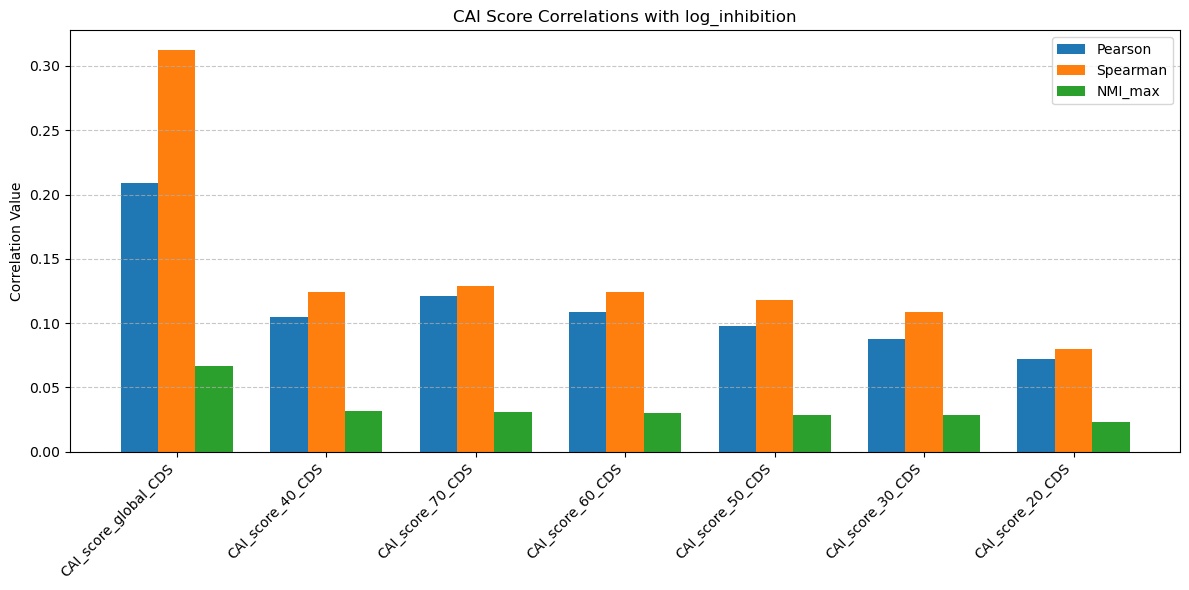

In [25]:
plot_feature_correlations_by_prefix(results_df, prefix='CAI_score', title='CAI Score Correlations with log_inhibition')